In [ ]:
!pip install -q diffusers transformers accelerate

!pip install -q controlnet_aux ip_adapter

!pip install -q torch torchvision opencv-python-headless pillow

!pip install -q optimum[onnxruntime-gpu]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.8 MB/s eta 0:00:00


Login no Hugging Face

In [ ]:
from huggingface_hub import login
from google.colab import userdata

token = userdata.get('HF_TOKEN')

login(token=token)

Verificação da GPU e Importações Principais

In [ ]:
import torch

# Verifica se a GPU (CUDA) está disponível
if torch.cuda.is_available():
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")
else:
    print("Nenhuma GPU detectada")

# Importações principais
from PIL import Image
import cv2
import numpy as np
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import OpenposeDetector
import torch.nn.functional as F

GPU detectada: Tesla T4


Imagens de Exemplo

Imagens carregadas:


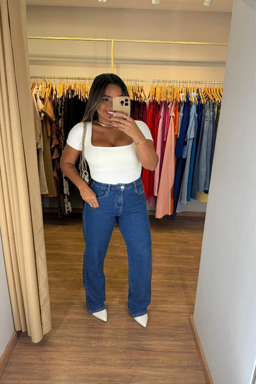

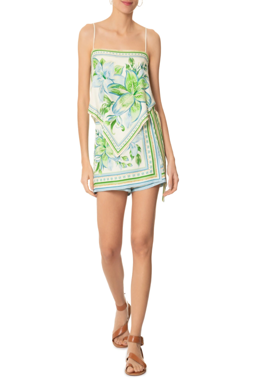

In [ ]:
#você pode baixar via wget. irei fazer o uso localmente
#!wget -q -O pessoa.jpg "https://plus.unsplash.com/premium_photo-1673199018447-383f33b1e3b0?w=800"
#!wget -q -O roupa.jpg "https://images.unsplash.com/photo-1620799140408-edc6d5f94003?w=800"

# Carrega as imagens com a biblioteca PIL
img_pessoa = Image.open("pessoa.jpeg").convert("RGB").resize((512, 768))
img_roupa = Image.open("roupa.jpeg").convert("RGB").resize((512, 768))

print("Imagens carregadas:")
display(img_pessoa.resize((256, 384)))
display(img_roupa.resize((256, 384)))

Criando Pose

Mapa de Pose (Esqueleto) gerado para o ControlNet:


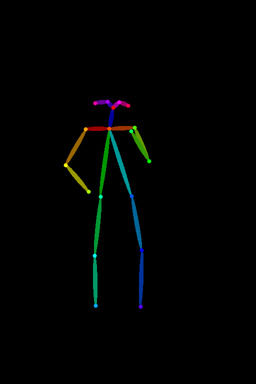

In [ ]:
openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

img_pose = openpose(img_pessoa)

print("Mapa de Pose (Esqueleto) gerado para o ControlNet:")
display(img_pose.resize((256, 384)))

Gerar Máscara de Inpainting

Máscara de Inpainting (área de pintura) gerada:


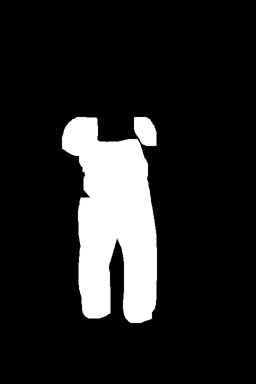

In [ ]:
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

#carrega um processador e um modelo de segmentação
processor = AutoImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model_seg = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")
model_seg.to("cuda")

# IDs das classes do modelo "mattmdjaga/segformer_b2_clothes"
# https://huggingface.co/mattmdjaga/segformer_b2_clothes#model-details
# 0: background       1: hair       2: head           3: face
# 4: upper-clothes    5: skirt      6: pants          7: dress
# 8: arm              9: leg       10: right-shoe   11: left-shoe
# 12: left-hand      13: right-hand 14: body-skin

#se você quer substituir um top e um shorts/saia,
#você precisa incluir as classes 4 (upper-clothes), 5 (skirt) e 6 (pants).
#se a nova peça for um vestido, mantenha a 7 (dress) também.

ids_roupa_desejada = [4, 5, 6, 7] # Upper-clothes, Skirt, Pants, Dress

# processa a imagem da pessoa
with torch.no_grad():
    inputs = processor(images=img_pessoa, return_tensors="pt").to("cuda")
    outputs = model_seg(**inputs)
    logits = outputs.logits

upsampled_logits = F.interpolate(logits,
                                size=img_pessoa.size[::-1],
                                mode='bilinear',
                                align_corners=False)

pred_seg = upsampled_logits.argmax(dim=1)[0]

mask_tensor = torch.zeros_like(pred_seg, dtype=torch.uint8)
for class_id in ids_roupa_desejada:
    mask_tensor[pred_seg == class_id] = 1

mask_np = (mask_tensor.cpu().numpy() * 255).astype(np.uint8)

# um kernel maior pode ajudar a cobrir mais áreas, mas cuidado para não cobrir demais
kernel = np.ones((20, 20), np.uint8) #aumentei o kernel para 20x20
mask_dilatada_np = cv2.dilate(mask_np, kernel, iterations=1)

img_mask = Image.fromarray(mask_dilatada_np).convert("L")

print("Máscara de Inpainting (área de pintura) gerada:")
display(img_mask.resize((256, 384)))

Carregar Pipeline de Difusão + ControlNet

In [ ]:
import torch

#carrega o modelo de controle de pose
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_openpose",
    torch_dtype=torch.float16 #float16 economiza VRAM
)

#carrega a pipeline principal (inpainting + controlnet)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None # verificador de segurança
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

print("Pipeline de Difusão, Inpainting e ControlNet carregada.")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Pipeline de Difusão, Inpainting e ControlNet carregada.


Carregar e Anexar o IP-Adapter


In [ ]:
#anexa o IP-Adapter ao pipeline que acabamos de carregar
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder="models",
    weight_name="ip-adapter_sd15.bin"
)

pipe.set_ip_adapter_scale(0.7)

Executar a geração da imagem

Gerando imagem..


  0%|          | 0/30 [00:00<?, ?it/s]

Imagem gerada


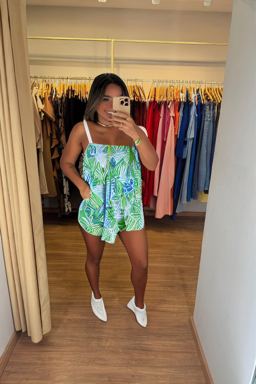

In [ ]:
# um bom prompt de texto é MUITO importante
prompt = "a photo of a woman wearing a blue hoodie, studio lighting, high quality"
neg_prompt = "low quality, bad anatomy, blurry, worst quality, deformed, mutated, ugly, disfigured, text, watermark, signature"

# define uma seed para que os resultados sejam reproduzíveis
generator = torch.Generator(device="cuda").manual_seed(42)

print("Gerando imagem.")
resultado = pipe(
    prompt=prompt,
    negative_prompt=neg_prompt,
    image=img_pessoa,
    mask_image=img_mask,
    control_image=img_pose,
    ip_adapter_image=img_roupa,
    num_inference_steps=30,
    generator=generator
).images[0]

print("Imagem final gerada")
display(resultado.resize((256, 384)))